In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Softmax
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import ks_2samp
from graph_utils import avg_path_length
from graph_utils import get_cluster_coeff
import pandas as pd

In [2]:
#Run me

nA = 5
class Node:
    '''kekw'''
    def __init__(self, Q):
        self.Q = Q #Q-func
        self.E = [] #Experience pool

def initQ(in_size, i, lr):
    '''Initializes Q-approximator for 
     - in_size : Size of input (should be number of states + number of actions)
     - i : 
    '''
    input_layer = Input(shape = (in_size,))
    dense_1 = Dense(128, activation = 'relu', use_bias = True, kernel_initializer="glorot_uniform")(input_layer)
    dense_2 = Dense(128, activation = 'relu', use_bias = True, kernel_initializer="glorot_uniform")(dense_1)
    dense_3 = Dense(64, activation = 'relu', use_bias = True, kernel_initializer="glorot_uniform")(dense_2)
    o = Dense(1, activation = None, use_bias = True, kernel_initializer="glorot_uniform")(dense_3)
    
    Q = Model(input_layer, o, name = "Q" + str(i))

#     def mse(y_true, y_pred):
#         return tf.math.reduce_mean(tf.math.square(y_true - y_pred)) * 0.5
    
    optimizer = tf.keras.optimizers.SGD(learning_rate = lr, momentum = 0.0)
    loss =  tf.keras.losses.MeanSquaredError()

    Q.compile(loss = loss, optimizer = optimizer)
                           
    return Q

class World:
    def __init__(self, n, num_agents):
        #self.state = np.zeros((num_agents, n * n)) #State, 46 x 100
        self.state_nums = np.zeros((num_agents,), dtype = int)
        self.n = n
        self.G = nx.Graph()
        self.G.add_nodes_from(range(num_agents))
        self.num_agents = num_agents
        
        for m in range(num_agents): #Start agents in random states
            r = np.random.randint(0, n * n)
            #self.state[m, r] = 1
            self.state_nums[m] = r
    
    def get_pos(self):
        out = []
        for i in range(self.num_agents):
            loc = self.state_nums[i]
            y, x = loc // self.n, loc % self.n
            x += np.random.uniform()
            y += np.random.uniform()
            out.append((x, y))
        return dict(enumerate(out, start = 0))
        
    def update_G(self):
        '''
        Searches for agents in the same state, and adds one to their edge's weight
        Also decreases any existing connections that are not maintained's weights by 1
        Removes any connections that have weight leq to 0
        '''
        updated = []
        rewards = np.zeros((self.num_agents, 1))
        for ag in range(self.state_nums.shape[0]): 
            #TODO: Maybe replace with np where to add edges?
            for tg in range(self.state_nums.shape[0]):
                #If same state, create/add weight to edge
                if ag != tg and self.state_nums[ag] == self.state_nums[tg] and (tg, ag) not in updated: 
                    if not self.G.has_edge(ag, tg):            #^ that fixes the double counhting but if i leave it
                        self.G.add_edge(ag, tg, weight = 1)  #it has better time complexity
                    else:
                        self.G.edges[ag, tg]['weight'] += 1 #<- thats why theyre 0.5 
                    updated.append((ag, tg))
                    updated.append((tg, ag))
                    
        for edge in self.G.edges():
            #Decrement all unupdated edges by 1, remove if less than 0
            if edge not in updated:
                self.G.edges[edge]['weight'] -= 0.005
                if self.G.edges[edge]['weight'] <= 0:
                    self.G.remove_edge(edge[0], edge[1])
                else:
                    rewards[edge[0]] += self.G.edges[edge]['weight']
                    rewards[edge[1]] += self.G.edges[edge]['weight']
            else:
                rewards[edge[0]] += self.G.edges[edge]['weight']
                rewards[edge[1]] += self.G.edges[edge]['weight']
            
        return rewards
    
                    
    def take_action(self, agent_id, a):
        #loc = np.argmax(self.state[agent_id, :])
        loc = self.state_nums[agent_id]
        y, x = loc // self.n, loc % self.n
        
        if a == 4: #down
            #self.state[agent_id, loc] = 0
            #self.state[agent_id, ((y + 1) * self.n) + x] = 1
            self.state_nums[agent_id] = ((y + 1) * self.n) + x
        elif a == 1: #up
           # self.state[agent_id, loc] = 0
            #self.state[agent_id, ((y - 1) * self.n) + x] = 1
            self.state_nums[agent_id] = ((y - 1) * self.n) + x
        elif a == 2: #left
            #self.state[agent_id, loc] = 0
            #self.state[agent_id, ((y) * self.n) + x - 1] = 1
            self.state_nums[agent_id] = ((y) * self.n) + x - 1
        elif a == 3: #right
            #self.state[agent_id, loc] = 0
            #self.state[agent_id, ((y) * self.n) + x + 1] = 1  
            self.state_nums[agent_id] = ((y) * self.n) + x + 1
        elif a == 0: #stay
            pass

def get_legals(s, n, nA):
    #Returns an array containig infinity if legal negative infinity if not
    legal_moves = np.ones((nA, 1)) * np.inf
    loc = s #np.argmax(s)
    y, x = loc // n, loc % n
    if y >= n - 1:
        legal_moves[4] = -np.inf
    if y == 0:
        legal_moves[1] = -np.inf
    if x == 0:
        legal_moves[2] = -np.inf
    if x == n - 1:
        legal_moves[3] = -np.inf

    return legal_moves
    
    #Make the graph pretty
def pp_graph(GRAPH_NAME, pos):
    #not short for pee pee graph
    widths = nx.get_edge_attributes(GRAPH_NAME, 'weight')
    nodelist = GRAPH_NAME.nodes()

    plt.figure(figsize=(10,10))

    #pos = nx.spring_layout(GRAPH_NAME)
    nx.draw_networkx_nodes(GRAPH_NAME, pos,
                           nodelist=nodelist,
                           node_size=100,
                           alpha=0.7)
    nx.draw_networkx_edges(GRAPH_NAME, pos,
                           edgelist = widths.keys(),
                           width=[val*1 for val in list(widths.values())],
                           edge_color='black',
                           alpha=0.75)
    plt.box(False)
    plt.show() 

    
def form_2d_graph(snums):
    xout, yout = [], []
    for s in snums:
        y, x = s // n, s % n
        xout.append((x + np.random.uniform())* 10)
        yout.append((y + np.random.uniform()) * 10)
    
    return xout, yout

def plot_2d_graph(x, y):
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xticks(np.arange(0, 100, 10))
    ax.set_yticks(np.arange(0, 100, 10))
    plt.scatter(x, y, s=10)
    plt.grid()
    plt.show()
    
def degree_distribution(graph, name = "bruh"):
    degree_sequence = sorted((d for _, d in graph.degree()), reverse=True)

    plt.figure(name, figsize=(8, 8))
    plt.bar(*np.unique(degree_sequence, return_counts=True))
    plt.xlabel('Degree')
    plt.ylabel('# of Nodes')

    plt.show()

    

In [3]:
def monk_it_up(epsilon_func, episode_length = 100, n = 10, y = 0.9, nAgents = 47, lr = 0.001, verbose = 1):
    '''
    Inputs:
     - epsilon_func: Function taht takes a timestep first, and then an agent id i, and returns a
                     epsilon between 0 and 1, keep in mind t starts at 0
     - episode_length: Number of steps in an episode
     - n: dimensions of world, will be nxn size
     - y: discount factor
     - nAgents: number of monkeys
     - lr: Learning rate, controls how fast neural net learns. Careful with putting lr too high, since 0.01 makes 
           gradient bounce around super fast, leading to a lot of nan predictions
     - verbose: 
         - if 0: prints nothing
         - if 1: prints Z-score and KSamps
         - if 2: prints graphs, z-score and Ksamps
           
    Returns:
    world object: Object representing the world, do world.G to get the graph, or world.state_nums for current board
                  state
    Avg path length list: List containing average path legnths every 10 timesteps (CURRENTLY NANS)
    clsuter_avgs: List containing average clustering coefficient every timestep
    zs : Numpy array of z-scores at each timestep (compared to our proximity graph, lower is better)
    samps : listo f KS-2  samples(tuples) at every timestep
    hist_gs : Graph of every timestep
    '''
    p_lengths = []
    cluster_avgs = []
    zs = []
    samps = []
    hist_gs = []
    
    worse_graph = nx.read_adjlist("./prog_g.adjlist")
    w_degree_sequence = np.unique(sorted((d for _, d in worse_graph.degree()), reverse=True), return_counts = True)[1]
    
    all_actions = np.eye(nA, dtype = np.float32)
    state = np.zeros((nA, n * n))
    vec = np.concatenate((state, all_actions), axis = 1)

    def policy(s, n, nA, epsilon, Q):
        legal_moves = get_legals(s, n, nA)
        #Epsilon exploration
        if np.random.uniform() < epsilon:
            r = np.random.randint(0, nA)
            while legal_moves[r] != np.inf:
                r = np.random.randint(0, nA)
            return r

        vec[:, s] = 1    
        out = np.argmax(np.minimum(Q(vec), legal_moves))
        vec[:, s] = 0

        return out

    upd_vec = np.zeros((1, n * n + nA))
    tg_vec = np.zeros((1, n * n + nA))

    def update(s, a, r, sp, gamma, Q):
        upd_vec[0, s] = 1
        upd_vec[0, s + a] = 1


        tg_vec[0, sp] = 1
        ap = policy(sp, n, nA, 0, Q)
        tg_vec[0, ap + sp] = 1
        Q.train_on_batch(upd_vec, r + gamma * Q(tg_vec))
        upd_vec[0, s], upd_vec[0, s + a], tg_vec[0, sp], tg_vec[0, ap + sp]  = 0, 0, 0, 0
        
    agents = [Node(initQ(n * n + nA, i, lr)) for i in range(nAgents)]

    world = World(n, nAgents)

    for t in range(episode_length):
        if t % 10 == 0 and verbose >= 1:
            print(f"Iter : {t}")
        

        for agent, i in zip(agents, range(nAgents)):
            epsilon = epsilon_func(t, i)
            sars = np.zeros((4,), dtype = int)
            s = world.state_nums[i]
            a = policy(s, n, nA, epsilon, agent.Q)

            world.take_action(i, a)

            sars[0] = s
            sars[1] = a
            sars[3] = world.state_nums[i]

            agent.E.append(sars) #r will come later

        R = world.update_G()

        for agent, i in zip(agents, range(nAgents)):
            agent.E[t][2] = R[i]
            s, a, r, sp = agent.E[np.random.choice(len(agent.E))]
            #s, a, r, sp = agent.E[t]
            #update(s, a, r, sp, y, agent.Q)
            
        p_len = None
        
        p_len = avg_path_length(world.G)
        p_lengths.append(p_len)
        if t % 5 == 0 and verbose >= 2:
            pp_graph(world.G, world.get_pos())
            print(f"Average path length: {p_len}")
            
        
        degree_sequence = np.unique(sorted((d for _, d in world.G.degree()), reverse=True),
                                    return_counts = True)[1]
        top = (degree_sequence.mean() - w_degree_sequence.mean()) 
        bot1 = np.square(np.std(degree_sequence) / np.sqrt(degree_sequence.shape[0]))
        bot2 = np.square(np.std(w_degree_sequence)) / np.sqrt(w_degree_sequence.shape[0])
        z = top / np.sqrt(bot1 + bot2)
        

        zs.append(z)

        s = ks_2samp(degree_sequence, w_degree_sequence)
        samps.append(s)
        if t % 10 == 0 and verbose >= 1:
            print(f"Z-score : {z}")
            print(f"ks_2 sample : {s}")

        if t % 50 == 0:
            hist_gs.append(world.G.copy())
        cluster_avgs.append(nx.average_clustering(world.G))
        
    return p_lengths, cluster_avgs, np.array(zs), samps, hist_gs

In [5]:
nAgents = 47
eps_funcs = np.random.uniform(0.2, 0.5, (nAgents,))
e_fixed = lambda t, i: 0.2
e_fixed_2 = lambda t, i: 0.4
e_fixed_3 = lambda t, i: 0.5
e_decay = lambda t, i : 1 / (t + 1)
e_brainoff = lambda t, i: 1

res = [0] * 3

#250 Iters, -0.025
for e, j in zip([e_fixed, e_fixed_2, e_fixed_3], range(3)):
    res[j] = []
    for i in range(3):
        print(f"iter: {i}")
        p_lengths, cluster_avgs, zs, samps, hist_gs = monk_it_up(e, 1500, n  = 10, nAgents = 47,y = 0.9, verbose = 0) #0.005
        res[j].append((p_lengths, cluster_avgs, zs, samps, hist_gs))
        #pp_graph(res[i][0].G, res[i][0].get_pos())

iter: 0
iter: 1
iter: 2
iter: 0
iter: 1
iter: 2
iter: 0
iter: 1
iter: 2


In [6]:
for iters in range(150, 1500, 10):  
    print(f"Iters: {iters}")
    for res_e in res:    
        mins = []
        stat = []
        p = []
        cluss = []
        pplens = []
        for run in res_e:
            plens, clus_avgs, zs, samp, _ = run
            mins.append(zs[iters])
            stat.append(samp[iters][0])
            p.append(samp[iters][1])
            cluss.append(clus_avgs[iters])
            pplens.append(plens[iters // 5])
        

        print(f"Average most recent Z-score: {np.mean(mins)}")
        print(f"Average most recent stat-score: {np.mean(stat)}")
        print(f"Average most recent p-value: {np.mean(p)}")
        print(f"Average most recent clustering coeff: {np.mean(cluss)}")
        print(f"Average most recent path length: {np.mean(pplens)}")
        print("\n")

Iters: 150
Average most recent Z-score: 1.9590926757168166
Average most recent stat-score: 0.5724941724941724
Average most recent p-value: 0.010929297273501832
Average most recent clustering coeff: 0.5035851490021176
Average most recent path length: 4.5266180148696336


Average most recent Z-score: 0.9521684347977635
Average most recent stat-score: 0.28747029114676176
Average most recent p-value: 0.3505810163775118
Average most recent clustering coeff: 0.5606120683480255
Average most recent path length: 4.10977489978415


Average most recent Z-score: 0.6466652725609116
Average most recent stat-score: 0.23834318416361758
Average most recent p-value: 0.5403078971791827
Average most recent clustering coeff: 0.5781069574591259
Average most recent path length: 3.930003083564601


Iters: 160
Average most recent Z-score: 1.6439607339460895
Average most recent stat-score: 0.44696969696969696
Average most recent p-value: 0.11997292105379664
Average most recent clustering coeff: 0.50598546294367

In [7]:
def find_keystones(graph, num_keystones, verbose=False):
    prox_keystones = []
    prox_cent = nx.betweenness_centrality(graph)
    for i in range(num_keystones):
        keystone = max(prox_cent.items(), key=lambda x: x[1])
        prox_cent.pop(keystone[0])
        prox_keystones.append(keystone)
    if verbose:
        print("Proximity Keystones & Their centrailty score")
        for i in prox_keystones: 
            print(f"{i}")
    return prox_keystones

def make_graphs(lot, label = ""):
    plen = []
    cavg = []
    z = []
    stats = []
    ps = []
    for g in lot:
        p_lengths, cluster_avgs, zs, samps, hist_gs = g
        plen.append(p_lengths)
        cavg.append(cluster_avgs)
        z.append(zs)
        stats.append([s[0] for s in samps])
        ps.append([s[1] for s in samps])
    plen = np.array(plen).mean(axis = 0)
    cavg = np.array(cavg).mean(axis = 0)
    z = np.array(z).mean(axis = 0)
    stats = np.array(stats).mean(axis = 0)
    ps = np.array(ps).mean(axis = 0)
    
    plt.plot(np.arange(1500), plen, linewidth=1)
    plt.xlabel('Timesteps')
    plt.ylabel('Average Path Length')
    plt.title(label)
    plt.ylim([2, 6.0])
    plt.savefig(f"./imgs/{label}APlens.png", dpi=500)
    plt.show()
    
    plt.plot(np.arange(1500), cavg, linewidth=1)
    plt.xlabel('Timesteps')
    plt.ylabel('Average Clustering Coefficient')
    plt.title(label)
    plt.ylim([0, 1.0])
    plt.savefig(f"./imgs/{label}ClusteringCoeff.png", dpi=500)
    plt.show()
    
    plt.plot(np.arange(1500), z, label = "Z-test score", linewidth=1)
    plt.xlabel('Timesteps')
    plt.ylabel('Average Z-score')
    plt.title(label)
    plt.ylim([0, 6.0])
    plt.savefig(f"./imgs/{label}Zscores.png", dpi=500)
    plt.show()
    
    plt.plot(np.arange(1500), stats, label = "KS Test Statistic", linewidth=1)
    plt.plot(np.arange(1500), ps, label = "KS p-values")
    plt.xlabel('Timesteps')
    plt.ylabel('Two-Sample KS Test')
    plt.ylim([0, 1.0])
    plt.title(label)
    plt.legend()
    plt.savefig(f"./imgs/{label}K2.png", dpi=500)
    plt.show()

def find_avg_keystones(lot, label = ""):
    i = 0
    all_keys = []
    for g in lot:
        p_lengths, cluster_avgs, zs, samps, hist_gs = g
        all_keys.append([c[1] for c in find_keystones(hist_gs[-1], 47, verbose = False)])
        
    plt.plot(np.arange(47), sorted(np.array(all_keys).mean(axis = 0)), label = "Betweenness Centrality", linewidth=1)
    plt.xlabel('Agents')
    plt.ylabel('Betweenness Centrality')
    plt.ylim([0, 0.08])
    plt.title(label)
    plt.legend()
    plt.savefig(f"./imgs/{label}avg_keystones.png", dpi=500)
    plt.show()
        
    

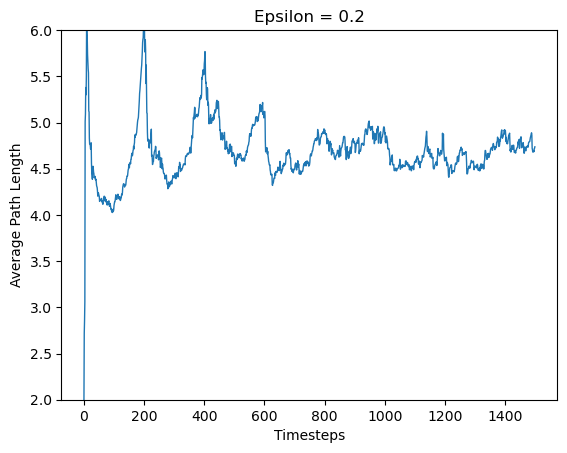

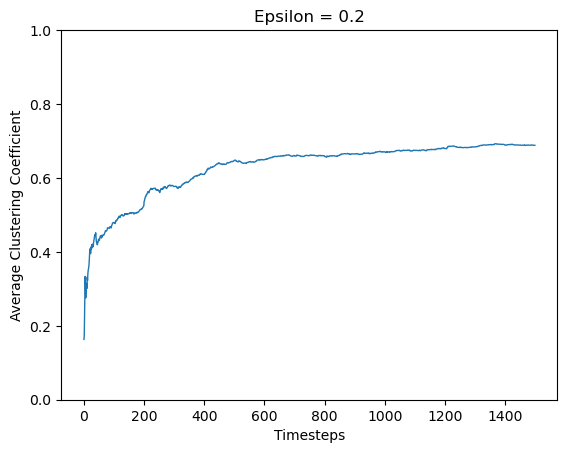

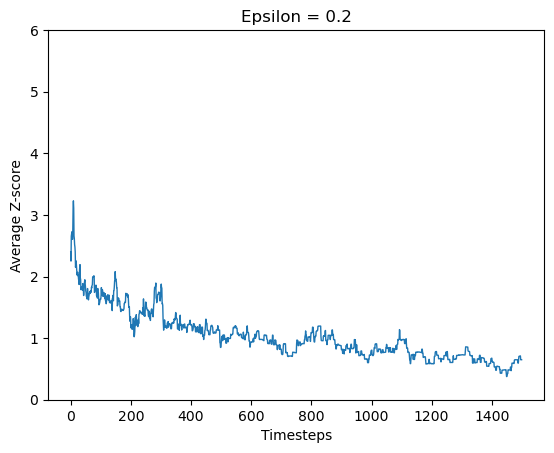

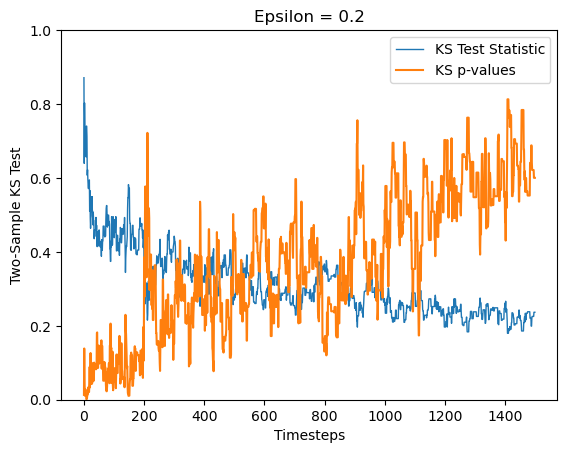

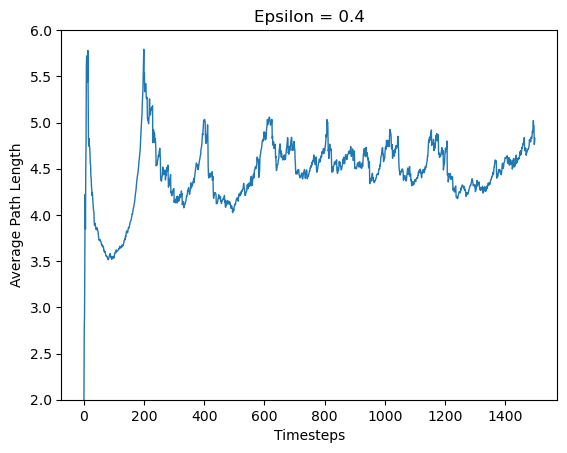

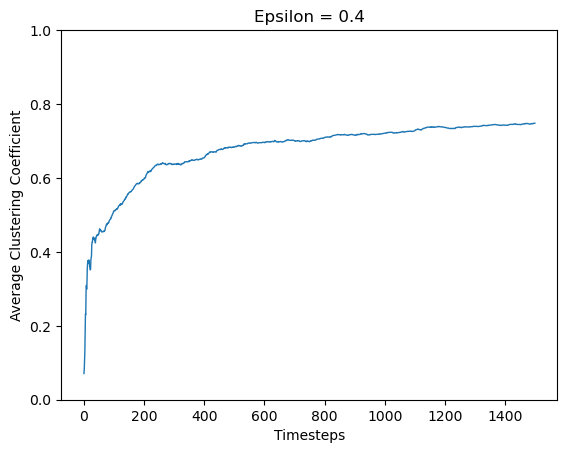

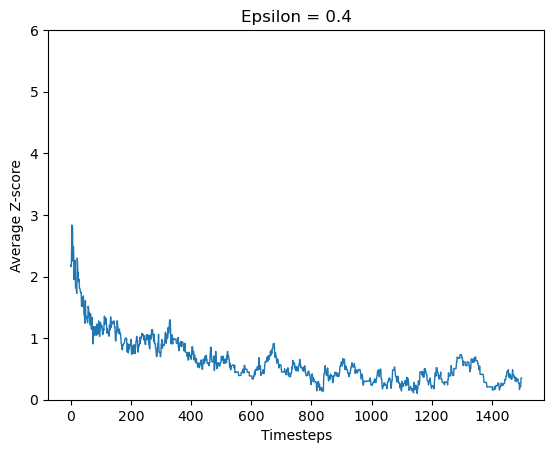

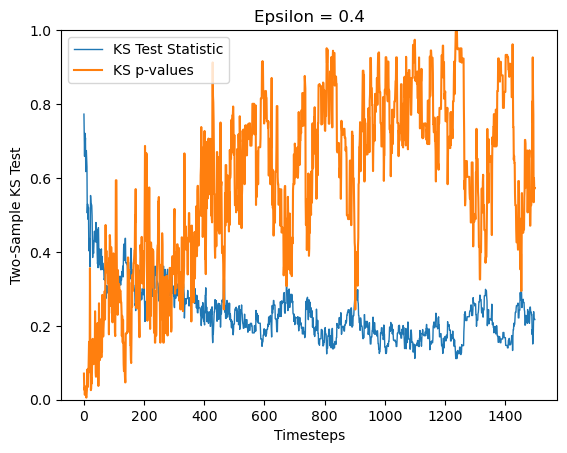

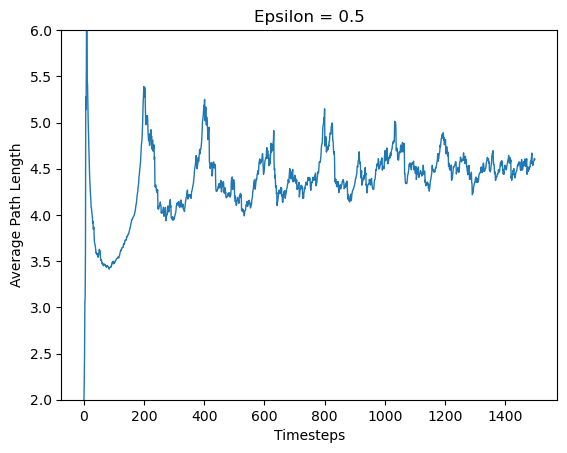

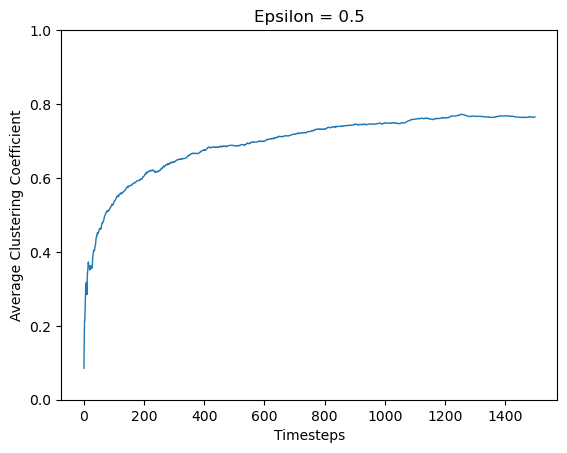

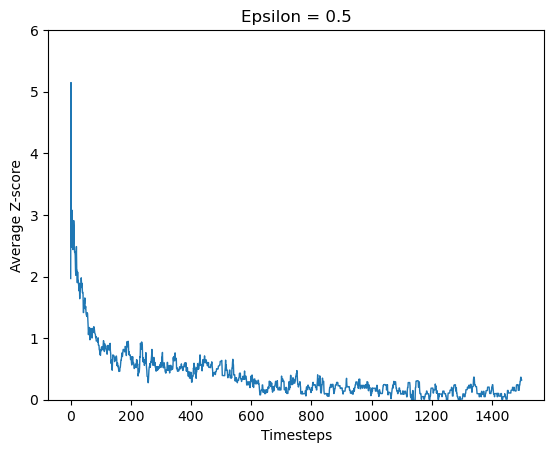

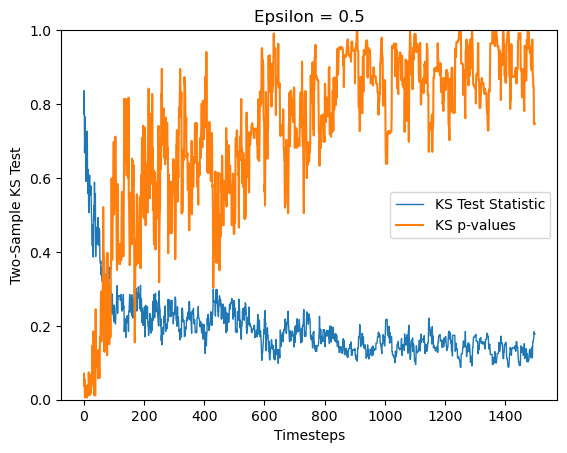

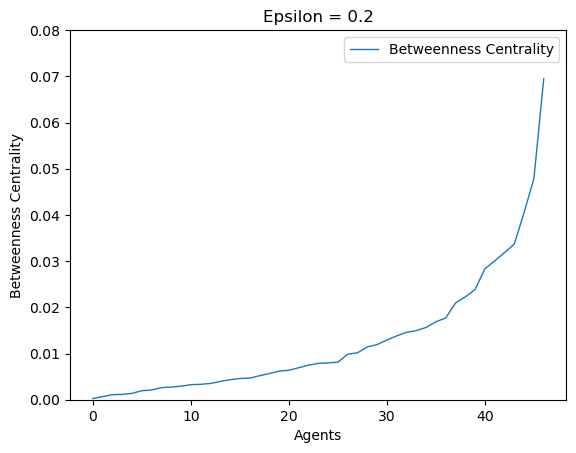

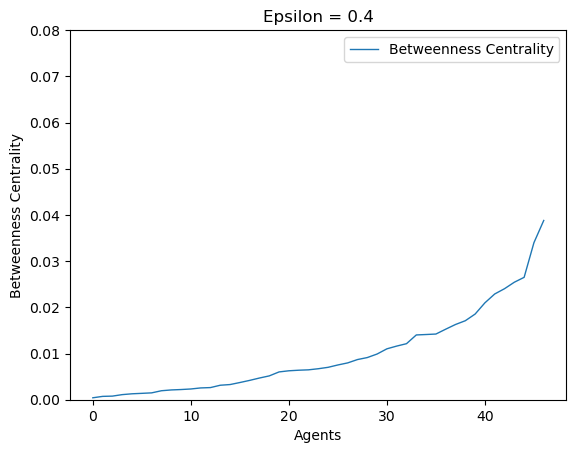

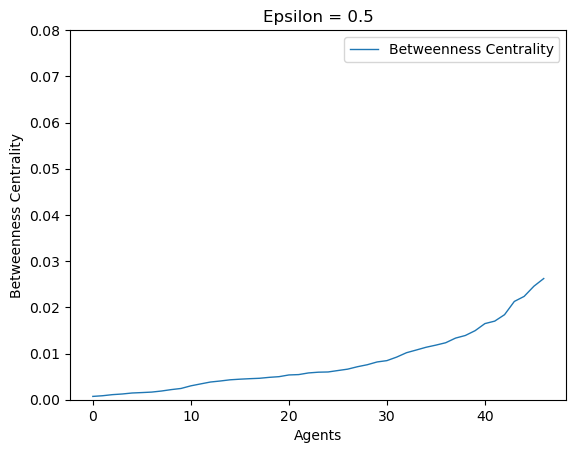

In [8]:
two = res[0]
four = res[1]
five = res[2]
make_graphs(two, "Epsilon = 0.2")
make_graphs(four, "Epsilon = 0.4")
make_graphs(five, "Epsilon = 0.5")
find_avg_keystones(two, "Epsilon = 0.2")
find_avg_keystones(four, "Epsilon = 0.4")
find_avg_keystones(five, "Epsilon = 0.5")